## Name       : Abinesh Manivannan
## Student Id : MAN22604977

# Importing required libraries :

In [1]:
import json
import torch
import spacy
import random
import spacy.cli
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from spacy import displacy
from tabulate import tabulate
from torchsummary import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Checking if the script is running in colab environment
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [3]:
# If not in colab, then have to print "Running the code locally"
if not(IN_COLAB):
  print('Running the code locally.')

# If in colab, mounting drive to access files
else:
  drive.mount('/content/drive')

Running the code locally.


In [4]:
# Downloading the English model from spaCy
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.4 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
# If not in colab, reading the dataset from local file
if not IN_COLAB:
    dataset = pd.read_csv("hotels.csv", encoding='latin-1')

# If in colab, resding the dataset from drive
else:
    dataset = pd.read_csv("/content/drive/MyDrive/hotels.csv", encoding='latin-1')

# Pre-processing :

In [6]:
# Copying the dataset
data1 = dataset.copy()

In [7]:
# Droping unnecessary columns
data1.drop(columns=['countyCode',' cityCode',' HotelCode',' Attractions'], inplace = True)

In [8]:
# Randomising the dataframe 'data'
data = data1.sample(frac=1, random_state=42) 

# Select the first 20,000 rows
data = data.head(20000)

In [9]:
# Convert the list of dictionaries to a DataFrame
save_data = pd.DataFrame(data)

# Specify the file path where you want to save the CSV file
file_path = 'hotels_20000.csv'

# Write the DataFrame to a CSV file
save_data.to_csv(file_path, index=False) 

### Label Encoding :

In [10]:
# Labelencoding the column 'HotelRating'
label_encoder = LabelEncoder()

data[' HotelRating'] = label_encoder.fit_transform(data[' HotelRating'])

rating_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Encoded ratings mapping:", rating_mapping)

Encoded ratings mapping: {0: 'All', 1: 'FiveStar', 2: 'FourStar', 3: 'OneStar', 4: 'ThreeStar', 5: 'TwoStar'}


### Custom Mapping : 

In [11]:
# As it is not appropiate to the values. So custom mapping to map the appropiate one
custom_mapping = {'All': 0, 'OneStar': 1, 'TwoStar': 2, 'ThreeStar': 3, 'FourStar': 4, 'FiveStar': 5}

data[' HotelRating'] = data[' HotelRating'].replace(custom_mapping)

reverse_mapping = {value: key for key, value in custom_mapping.items()}
print("Encoded ratings mapping:", reverse_mapping)

Encoded ratings mapping: {0: 'All', 1: 'OneStar', 2: 'TwoStar', 3: 'ThreeStar', 4: 'FourStar', 5: 'FiveStar'}


In [12]:
data.columns = map(lambda x: x.lower().strip(), data.columns)

In [13]:
# Selecting random description from the dataset
doc = nlp(np.random.choice(data['description']))

# Vizualizing the named entities from the processed description
displacy.render(doc, style='ent', jupyter=True, options={'distance': 120})

### Tokenization : 

In [14]:
# Data cleaning: fill NaNs and convert to string
data['description'] = data['description'].fillna('missing')
data['description'] = data['description'].astype(str)

In [15]:
# Data cleaning: fill NaNs and convert to string
data['hotelfacilities'] = data['hotelfacilities'].fillna('missing')
data['hotelfacilities'] = data['hotelfacilities'].astype(str)

In [16]:
# Tokenization and vocabulary building
def tokenize(text):
    doc = nlp(text.lower())
    return [token.text for token in doc if not token.is_stop and not token.is_punct and token.text.strip()]

In [17]:
# Assuming data is your DataFrame
data['tokenized'] = data['description'].apply(tokenize)

In [18]:
data['tokenized'] = data['hotelfacilities'].apply(tokenize)

In [19]:
data.head()

,countyname,cityname,hotelname,hotelrating,address,description,faxnumber,hotelfacilities,map,phonenumber,pincode,hotelwebsiteurl,tokenized
484636,Italy,San Lorenzo al Mare,Hotel Riviera dei Fiori,2,Via Aurelia 3 18017 San Lorenzo al MareImperia,<p>HeadLine : Near Spiaggia della Marina</p><p...,39-0183-930 125,Garden Free newspapers in lobby Full-service s...,43.860659|7.969613,39-0183-745 100,18017,http://www.hotelrivieradeifiori.it/de/,"[garden, free, newspapers, lobby, service, spa..."
73433,Austria,Zillertal,Sport und Wellnesshotel Held,2,Kleinbodenerstraße 6 6263 FügenZillertal,<p>HeadLine : Near Erlebnistherme Zillertal</p...,43-528-8623867,Wheelchair accessible (may have limitations) W...,47.334929|11.855272,43-528-862386,6263,http://www.held.at/,"[wheelchair, accessible, limitations, wheelcha..."
457185,Italy,Mazara del Vallo,Sud 12 Ville sul Mediterraneo,3,Via Formia 50 91026 Mazara del ValloSicily,<p>HeadLine : Near Tonnarella</p><p>Location :...,011-39-3407377658,Private beach nearby Lockers available Handrai...,37.660746|12.569689,011-39-3407377658,91026,http://www.sud12.it,"[private, beach, nearby, lockers, available, h..."
832995,United Kingdom,Leith,Home By Leiths Shore,4,Maritime Street,<p>HeadLine : In Edinburgh (Leith)</p><p>Locat...,NaN,Free wired Internet Smoke-free property Multil...,55.974407|-3.168609,44-7441909799,EH6 6SA,NaN,"[free, wired, internet, smoke, free, property,..."
87611,Brazil,Bombinhas,Cobertura Costa Do Sol,0,1860 Avenida Aroeira Da Praia,Situated in Bombinhas and only 60 metres from ...,NaN,Parking Pets allowed Free parking internet ser...,-27.18331|-48.50056,NaN,88215 000,https://www.booking.com/hotel/br/cobertura-cos...,"[parking, pets, allowed, free, parking, intern..."


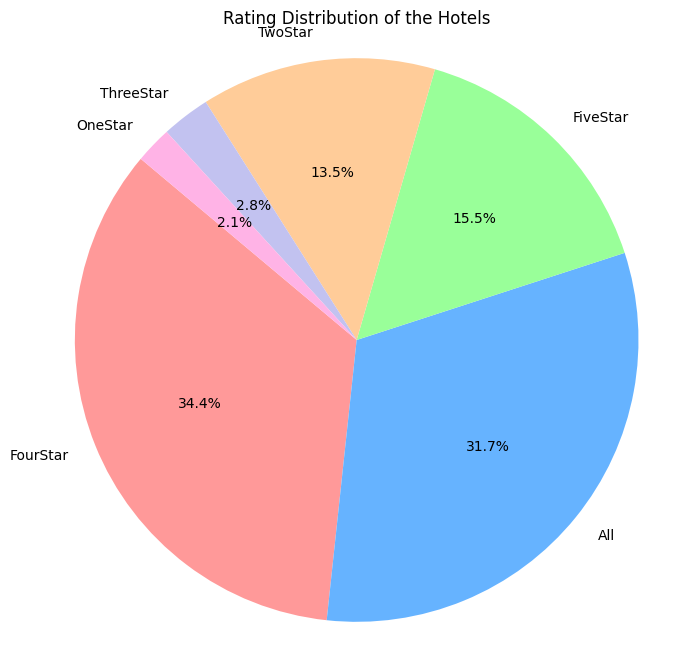

In [21]:
import matplotlib.pyplot as plt

# Counting the frequency of each rating
rating_counts = data['hotelrating'].value_counts()

# Mapping numerical ratings to textual labels
rating_labels = {0: 'All', 1: 'OneStar', 2: 'TwoStar', 3: 'ThreeStar', 4: 'FourStar', 5: 'FiveStar'}

# Define a list of colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0','#ffb3e6']

# Using a Matplotlib colormap
# You can uncomment the next line to see how it applies a colormap
# colors = plt.cm.Pastel1.colors[:len(rating_counts)]

plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=[rating_labels[rating] for rating in rating_counts.index], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Rating Distribution of the Hotels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [22]:
# Building vocabulary function
def build_vocab(tokenized_texts):
    vocab = {}
    idx = 0
    
    # Loop through each list of tokens in the tokenized_texts.
    for tokens in tokenized_texts:
        for token in tokens:
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    # Return the completed vocabulary dictionary.            
    return vocab

vocab = build_vocab(data['tokenized'])

In [ ]:
import os

# Function to build vocabulary
def build_vocab(tokenized_texts):
    vocab = {}
    idx = 0
    for tokens in tokenized_texts:
        for token in tokens:
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

# Function to save the vocabulary to a JSON file
def save_vocab_to_json(vocab, filepath):
    # Check if the directory exists before saving
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)  # Create the directory if it does not exist
    
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(vocab, f, ensure_ascii=False, indent=4)

# Assuming 'data['tokenized']' is available from your dataset processing
vocab = build_vocab(data['tokenized'])

# Save the vocabulary to a JSON file
vocab_file_path = 'data/vocab.json'
save_vocab_to_json(vocab, vocab_file_path)

In [23]:
# # GloVe embedding loading and embedding matrix creation functions
# def load_embeddings(path):
#     embeddings_index = {}
#     with open(path, 'r', encoding='utf-8') as f:
#         for line in f:
#             parts = line.split()
#             word = parts[0]
#             vector_parts = parts[1:]
#             try:
#                 coefs = np.asarray(vector_parts, dtype='float32')
#                 embeddings_index[word] = coefs
#             except ValueError:
#                 print(f"Error converting the following parts to floats: {vector_parts}")
#     return embeddings_index

# Loading GloVe embedding and embedding matrix creation functions
def load_embeddings(path):
    embeddings_index = {}
    errors = 0
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector_parts = parts[1:]
            try:
                coefs = np.asarray(vector_parts, dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                errors += 1  # Increment the error count
    if errors > 0:
        print(f"Skipped {errors} lines with formatting issues.")
    return embeddings_index


In [24]:
# Embedding Matrix Creation for NLP Models
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    # Iterating over the word_index dictionary
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [25]:
# Loading pre-trained embeddings from a file
embeddings_index = load_embeddings('glove.840B.300d.txt')
embedding_dim = 300

# Creating an embedding matrix using the vocabulary from a model and the loaded embeddings.
embedding_matrix = create_embedding_matrix(vocab, embeddings_index, embedding_dim)
pretrained_embeddings = torch.tensor(embedding_matrix, dtype=torch.float32)

Skipped 20 lines with formatting issues.


In [26]:
# Setting up for training
class HotelDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(text) for text in texts]  # Converting texts to tensors
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [27]:
# Creating datasets and dataloaders
texts = list(map(lambda x: [vocab.get(word, 0) for word in x], data['tokenized']))
labels = data['hotelrating'].values

In [28]:
# Converting texts to a uniform length for modeling
def pad_sequences(texts, maxlen=100):
    return np.array([np.pad(text, (0, maxlen - len(text)), mode='constant') if len(text) < maxlen else text[:maxlen] for text in texts])

texts_padded = pad_sequences(texts)

# Splitting the data into train and test sets
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_padded, labels, test_size=0.2, random_state=42)

# Create Dataset instances
train_dataset = HotelDataset(torch.tensor(train_texts, dtype=torch.long), torch.tensor(train_labels, dtype=torch.long))
test_dataset = HotelDataset(torch.tensor(test_texts, dtype=torch.long), torch.tensor(test_labels, dtype=torch.long))

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Use a custom collate function to pad text sequences
def collate_batch(batch):
    (texts, labels) = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # Padding value 0 for <PAD>
    labels = torch.stack(labels)
    return texts_padded, labels

# When creating the DataLoader, specify the custom collate function
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)

/var/folders/sd/6m81mt411jxfsqsc4d3ctrg40000gn/T/ipykernel_2064/164197450.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.texts = [torch.tensor(text) for text in texts]  # Convert texts to tensors
/var/folders/sd/6m81mt411jxfsqsc4d3ctrg40000gn/T/ipykernel_2064/164197450.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels)


# Generating Hybrid Model :

#### Tried with LSTM HybridModel :

In [69]:
# class HybridHotelModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, pretrained_embeddings=None):
#         super(HybridHotelModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
#         if pretrained_embeddings is not None:
#             self.embedding.weight = nn.Parameter(pretrained_embeddings)
#             self.embedding.weight.requires_grad = True 
        
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
#                             batch_first=True, bidirectional=bidirectional, dropout=0.5 if num_layers > 1 else 0)
        
#         self.dropout = nn.Dropout(0.5)
        
#         # Adjusting batch normalization input size to match LSTM output size
#         self.batch_norm = nn.BatchNorm1d(hidden_dim * 2 if bidirectional else hidden_dim)
        
#         # Adding more fully connected layers for better representation learning
#         self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, output_dim)
        
#         self.relu = nn.ReLU()
#         # Softmax activation for multi-class classification
#         self.softmax = nn.Softmax(dim=1)  

#     def forward(self, x):
#         embedded = self.embedding(x)
#         lstm_output, (lstm_hidden, _) = self.lstm(embedded)
        
#         # Concatenating forward and backward hidden states if bidirectional
#         if lstm_hidden.shape[0] > 1:
#             lstm_hidden = torch.cat((lstm_hidden[-2,:,:], lstm_hidden[-1,:,:]), dim=1)
#         else:
#             lstm_hidden = lstm_hidden[-1,:,:]

#         lstm_hidden = self.dropout(lstm_hidden)
#         lstm_hidden = self.batch_norm(lstm_hidden)
        
#         # Applying ReLU activation function after the first fully connected layer
#         out = self.fc1(lstm_hidden)
#         out = self.relu(out)
        
#         # Applying dropout before the second fully connected layer
#         out = self.dropout(out)
        
#         out = self.fc2(out)
#         out = self.relu(out)
        
#         # Applying dropout before the final fully connected layer
#         out = self.dropout(out)
        
#         out = self.fc3(out)
        
#         # Appling softmax activation to get class probabilities
#         out = self.softmax(out)  
#         return out

#### Tried with only GRU RNN Model : 

In [ ]:
# class GRUHotelModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional):
#         super(GRUHotelModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, 
#                           batch_first=True, bidirectional=bidirectional, dropout=0.5)
#         self.dropout = nn.Dropout(0.5)
#         self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
#         self.activation = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = self.embedding(x)
#         x, _ = self.gru(x)
#         x = self.dropout(x[:, -1])
#         x = self.fc(x)
#         return self.activation(x)

#### Combination of both LSTM and GRU RNN Model :

In [29]:
class HybridRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.5, bidirectional=False):
        super(HybridRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.gru = nn.GRU(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.activation = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hidden, cell) = self.lstm(x)
        x, hidden = self.gru(x)
        x = self.dropout(x[:, -1])
        x = self.fc(x)
        return self.activation(x)

In [30]:
# Determining the device to use 'cuda' (GPU), if not 'CPU'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter Tuning :

### a) Manual tuning : 

In [ ]:
# # Fine-Tuning Hyperparameters

# vocab_size = len(vocab)
# embedding_dim = 300
# hidden_dim = 256 #512
# output_dim = 6  
# num_layers = 2
# bidirectional = True
# pretrained_embeddings = None  

# # Initializing the hybrid model with specified hyperparameters
# hybrid_model = HybridHotelModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, pretrained_embeddings)

# # Moving model to the device (GPU)
# hybrid_model.to(device)

# # Defining the loss function (Cross-Entropy Loss) and optimizer
# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification


# # optimizer = optim.SGD(hybrid_model.parameters(), lr=0.01, momentum=0.9)
# # optimizer = optim.SGD(hybrid_model.parameters(), lr=0.001, momentum=0.9)
# # optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001
# # optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001)

# optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001)

### b) Automatic Hyperparameter Tuning :

In [31]:
# Random samples for hyperparameter
def sample_hyperparameters():
    return {
        'hidden_dim': random.choice([64, 128, 256]),
        'num_layers': random.choice([1, 2, 3]),
        'learning_rate': random.choice([0.01, 0.001, 0.0001]),
        'dropout_rate': random.choice([0.1, 0.2, 0.5]),
        'bidirectional': random.choice([True, False]),
    }

In [34]:
# Training and evaluating the model with provided hyperparameters
def train_and_evaluate(hparams, train_loader, vocab_size, output_dim):
    model = HybridRNNModel(vocab_size=vocab_size,
                          embedding_dim=300,
                          hidden_dim=hparams['hidden_dim'],
                          output_dim=output_dim,
                          num_layers=hparams['num_layers'],
                          bidirectional=hparams['bidirectional']).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
    criterion = nn.NLLLoss()
    
    # Simplified training loop
    for epoch in range(3):  # Limited epochs for quick demonstration
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

In [33]:
# Assuming the preparation of texts and labels has been done properly before this:
train_dataset = HotelDataset(texts, labels)  
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)

vocab_size = len(vocab) + 1  # '+1' accounts for potential padding token or out-of-vocabulary tokens
output_dim = len(set(labels))  

# # Running the hyperparameter tuning
# best_loss = float('inf')
# best_hparams = None

# for _ in range(10):  
#     hparams = sample_hyperparameters()
#     loss = train_and_evaluate(hparams, train_loader, vocab_size, output_dim)
#     print(f"Loss: {loss}, Params: {hparams}")
#     if loss < best_loss:
#         best_loss = loss
#         best_hparams = hparams

# print(f"Best Loss: {best_loss}, Best Hyperparameters: {best_hparams}")

Loss: 1.408470869064331, Params: {'hidden_dim': 256, 'num_layers': 2, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'bidirectional': False}
Loss: 1.0099233388900757, Params: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'bidirectional': True}
Loss: 1.1672134399414062, Params: {'hidden_dim': 128, 'num_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'bidirectional': False}
Loss: 1.4657036066055298, Params: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'bidirectional': False}
Loss: 1.2151992321014404, Params: {'hidden_dim': 256, 'num_layers': 3, 'learning_rate': 0.0001, 'dropout_rate': 0.1, 'bidirectional': True}
Loss: 1.2054696083068848, Params: {'hidden_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'bidirectional': True}
Loss: 1.465735673904419, Params: {'hidden_dim': 256, 'num_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'bidirectional': True}
Loss: 1.5638072490692139, 

best_hparams = {
    "hidden_dim": 128, 
    "num_layers": 2, 
    "learning_rate": 0.01,
    "dropout_rate": 0.2, 
    "bidirectional": False
}

In [35]:
if best_hparams:
    # Creating the model with the best hyperparameters
    model = HybridRNNModel(
        vocab_size=len(vocab) + 1,  # Including +1 for <PAD> or <UNK> if not counted in `len(vocab)`
        embedding_dim=300,  
        hidden_dim=best_hparams['hidden_dim'],
        output_dim=len(set(labels)),  
        num_layers=best_hparams['num_layers'],
        bidirectional=best_hparams['bidirectional']
    ).to(device)
    print("Model instantiated with best hyperparameters.")
else:
    print("Failed to instantiate model: No valid hyperparameters found.")

Model instantiated with best hyperparameters.


In [36]:
# Defining the loss function (Cross-Entropy Loss) and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_hparams['learning_rate'])

# Training the Model :

In [37]:
# Training the model with given train_loader, criterion and optimizer 
def train_model(model, train_loader, criterion, optimizer, num_epochs=30):
    train_losses = []  
    train_accuracies = []  
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    return train_losses, train_accuracies

# Train the model and capture training losses and accuracies
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=30)

Epoch 1: 100%|██████████| 313/313 [02:11<00:00,  2.37it/s]


Epoch 1: Loss: 1.4652, Accuracy: 0.3668


Epoch 2: 100%|██████████| 313/313 [02:13<00:00,  2.35it/s]


Epoch 2: Loss: 1.3013, Accuracy: 0.5314


Epoch 3: 100%|██████████| 313/313 [02:15<00:00,  2.31it/s]


Epoch 3: Loss: 1.2123, Accuracy: 0.5490


Epoch 4: 100%|██████████| 313/313 [02:14<00:00,  2.33it/s]


Epoch 4: Loss: 1.1121, Accuracy: 0.5895


Epoch 5: 100%|██████████| 313/313 [02:15<00:00,  2.31it/s]


Epoch 5: Loss: 1.0481, Accuracy: 0.6226


Epoch 6: 100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


Epoch 6: Loss: 0.9886, Accuracy: 0.6448


Epoch 7: 100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


Epoch 7: Loss: 0.9319, Accuracy: 0.6692


Epoch 8: 100%|██████████| 313/313 [02:18<00:00,  2.25it/s]


Epoch 8: Loss: 0.8623, Accuracy: 0.6979


Epoch 9: 100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


Epoch 9: Loss: 0.7981, Accuracy: 0.7250


Epoch 10: 100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


Epoch 10: Loss: 0.7309, Accuracy: 0.7479


Epoch 11: 100%|██████████| 313/313 [02:18<00:00,  2.25it/s]


Epoch 11: Loss: 0.6682, Accuracy: 0.7734


Epoch 12: 100%|██████████| 313/313 [02:18<00:00,  2.27it/s]


Epoch 12: Loss: 0.6102, Accuracy: 0.7978


Epoch 13: 100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


Epoch 13: Loss: 0.5565, Accuracy: 0.8151


Epoch 14: 100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


Epoch 14: Loss: 0.5054, Accuracy: 0.8356


Epoch 15: 100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


Epoch 15: Loss: 0.4646, Accuracy: 0.8509


Epoch 16: 100%|██████████| 313/313 [02:18<00:00,  2.25it/s]


Epoch 16: Loss: 0.4347, Accuracy: 0.8607


Epoch 17: 100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


Epoch 17: Loss: 0.4017, Accuracy: 0.8738


Epoch 18: 100%|██████████| 313/313 [02:18<00:00,  2.25it/s]


Epoch 18: Loss: 0.3638, Accuracy: 0.8844


Epoch 19: 100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


Epoch 19: Loss: 0.3493, Accuracy: 0.8900


Epoch 20: 100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


Epoch 20: Loss: 0.3280, Accuracy: 0.8982


Epoch 21: 100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


Epoch 21: Loss: 0.3018, Accuracy: 0.9047


Epoch 22: 100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


Epoch 22: Loss: 0.2919, Accuracy: 0.9083


Epoch 23: 100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


Epoch 23: Loss: 0.2775, Accuracy: 0.9135


Epoch 24: 100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


Epoch 24: Loss: 0.2728, Accuracy: 0.9152


Epoch 25: 100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


Epoch 25: Loss: 0.2585, Accuracy: 0.9207


Epoch 26: 100%|██████████| 313/313 [02:13<00:00,  2.34it/s]


Epoch 26: Loss: 0.2591, Accuracy: 0.9183


Epoch 27: 100%|██████████| 313/313 [02:13<00:00,  2.35it/s]


Epoch 27: Loss: 0.2495, Accuracy: 0.9228


Epoch 28: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch 28: Loss: 0.2306, Accuracy: 0.9295


Epoch 29: 100%|██████████| 313/313 [02:14<00:00,  2.33it/s]


Epoch 29: Loss: 0.2429, Accuracy: 0.9244


Epoch 30: 100%|██████████| 313/313 [02:20<00:00,  2.22it/s]

Epoch 30: Loss: 0.2262, Accuracy: 0.9295


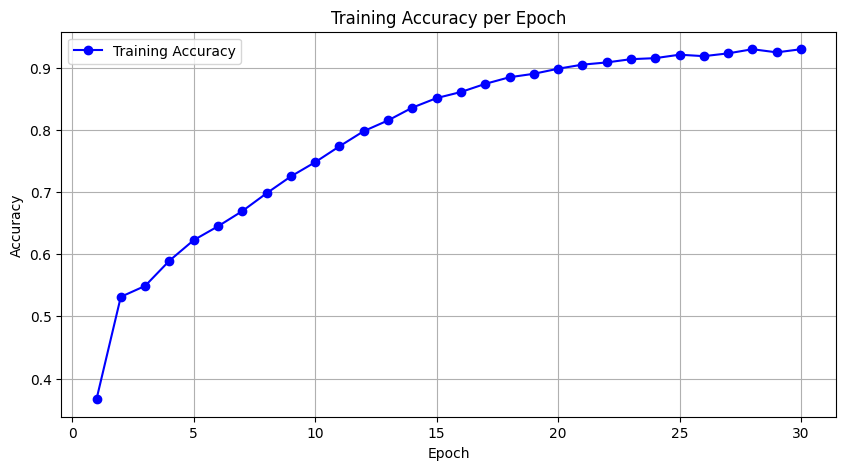

In [38]:
# Plotting Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'o-', color="b", label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

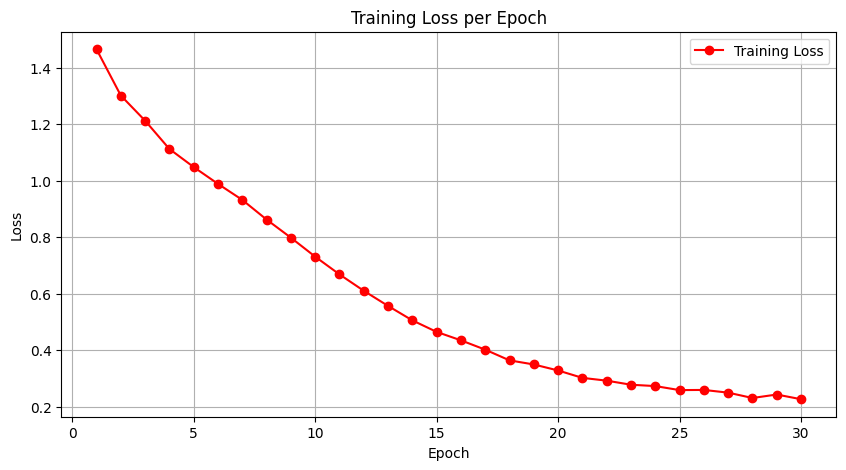

In [39]:
# Plotting Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', color="r", label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model saving :

In [43]:
# Saving the model 
torch.save(model.state_dict(), 'hotelhybrid_model.pth')

# Model Evaluation (With Test Dataset):

In [44]:
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc="Evaluating"):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return all_labels, all_predictions

# Evaluate the model and get labels and predictions
actual_labels, predicted_labels = evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 63/63 [00:04<00:00, 12.92it/s]

Test Loss: 0.4029, Test Accuracy: 0.8638


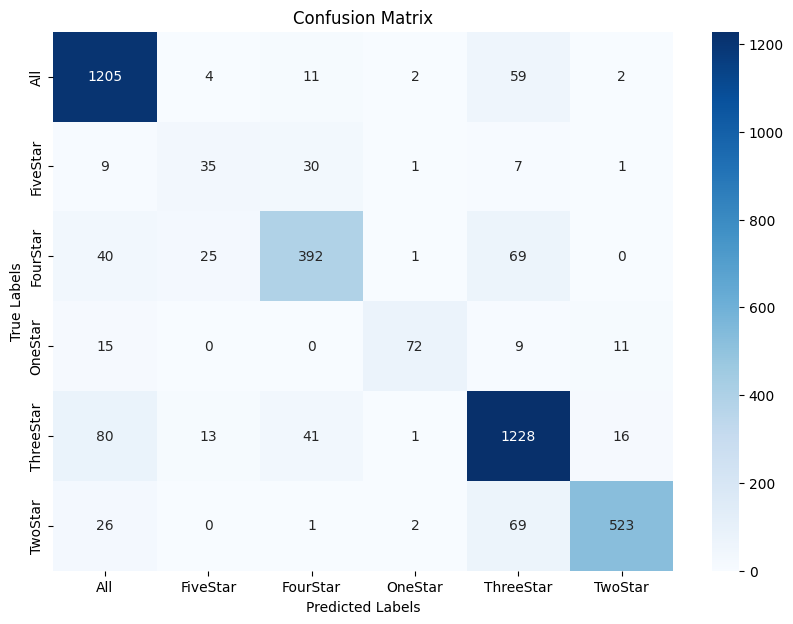

In [45]:
def plot_confusion_matrix(actual_labels, predicted_labels, classes):
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have label_encoder used to encode labels, you can use its classes_ attribute for class names
class_names = label_encoder.classes_  # This should be defined where you fit your LabelEncoder
plot_confusion_matrix(actual_labels, predicted_labels, class_names)

# Predicting with the same data from the dataset : 

In [57]:
def tokenizer(text):
    # Tokenizes the text into a list of tokens
    doc = nlp(text.lower())
    return [token.text for token in doc if not token.is_punct and not token.is_space]

def preprocess_text(text):
    return tokenizer(text)

def predict(text, model, vocab):
    model.eval()
    processed_text = preprocess_text(text)
    input_tensor = encode_and_pad(processed_text, vocab)  # Ensure this function exists and works
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    return prediction.item(), probabilities.squeeze()  # Remove batch dimension for single example

def encode_and_pad(processed_text, vocab, max_length=100):
    # Ensure each token in processed_text has a corresponding index in vocab
    encoded = [vocab.get(token, vocab.get("<UNK>", 0)) for token in processed_text]  # Use vocab.get("<UNK>", 0) for unknown tokens
    # Pad the sequence
    if len(encoded) < max_length:
        encoded += [vocab.get("<PAD>", 0)] * (max_length - len(encoded))
    else:
        encoded = encoded[:max_length]
    return torch.tensor([encoded], dtype=torch.long)  # Adding batch dimension

In [58]:
sample_text = "Hotel with swimming pool, buffet breakfast, gym and car parking"
prediction, probabilities = predict(sample_text, model, vocab)
predicted_rating = rating_mapping[prediction]

print(f"Predicted Rating: {predicted_rating}")
print(f"Probabilities: {probabilities}")

Predicted Rating: ThreeStar
Probabilities: tensor([1.8584e-03, 1.6141e-03, 6.2874e-02, 1.2721e-04, 9.3184e-01, 1.6862e-03])


# Predicting the model with unseen manually entered data :

In [59]:
def preprocess_text(text):
    """Tokenizes text using the loaded spaCy model and returns non-punctuated tokens."""
    return [token.text for token in nlp(text.lower()) if not token.is_punct and not token.is_space]

def encode_and_pad(processed_text, vocab, max_length=100):
    """Encodes and pads the processed text according to the vocabulary and maximum length."""
    encoded = [vocab.get(token, vocab.get("<UNK>", 0)) for token in processed_text]  # Use vocab.get("<UNK>", 0) for unknown tokens
    padded = encoded + [vocab.get("<PAD>", 0)] * (max_length - len(encoded)) if len(encoded) < max_length else encoded[:max_length]
    return torch.tensor([padded], dtype=torch.long)  # Adding batch dimension for model input

def predict_rating(description, facility, model, vocab):
    """Predicts the rating based on provided description and facility."""
    combined_text = description + " " + facility  # Combine description and facility into one string
    processed_text = preprocess_text(combined_text)  # Process the text through the same pipeline as during training
    input_tensor = encode_and_pad(processed_text, vocab, max_length=100)  # Ensure to match the max_length used in training
    input_tensor = input_tensor.to(device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    predicted_rating = rating_mapping[prediction.item()]  # Map the numeric prediction back to the label
    confidence = probabilities[0][prediction.item()].item()  # Get the probability of the predicted class
    return predicted_rating, confidence

# Example Usage:
description = "Hotel offers a luxurious escape in the heart of the city, blending modern amenities with charming, sophisticated decor. Its 200 elegantly furnished rooms provide breathtaking views of the urban skyline, making it a perfect retreat for both leisure and business travelers."
facility = "The hotel boasts a range of high-end amenities including multiple gourmet restaurants, a rooftop garden, a comprehensive spa, and elegant ballrooms. The guest rooms and suites are sumptuously appointed with fine furnishings and state-of-the-art technology, ensuring a comfortable and lavish stay."
predicted_rating, confidence = predict_rating(description, facility, model, vocab)
print(f"Predicted Rating: {predicted_rating} with confidence {confidence:.2%}")

Predicted Rating: ThreeStar with confidence 99.80%


In [70]:
# Printing Model Summary 
class HybridRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.5, bidirectional=False):
        super(HybridRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.gru = nn.GRU(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.activation = nn.LogSoftmax(dim=1)

    def forward(self, x):
        outputs = []
        outputs.append(["Input", x.shape])
        x = self.embedding(x)
        outputs.append(["Embedding", x.shape])
        x, (hidden, cell) = self.lstm(x)
        outputs.append(["LSTM", x.shape])
        x, hidden = self.gru(x)
        outputs.append(["GRU", x.shape])
        x = self.dropout(x[:, -1])
        outputs.append(["Dropout", x.shape])
        x = self.fc(x)
        outputs.append(["Fully Connected", x.shape])
        x = self.activation(x)
        outputs.append(["LogSoftmax", x.shape])
        return outputs

# Model parameters
vocab_size = 1000
embedding_dim = 300
hidden_dim = 128
output_dim = 5
num_layers = 2
bidirectional = True

# Initialize the model
model = HybridRNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional=bidirectional)
model.to('cpu')  # Switch to 'cuda' if GPU is available

# Dummy input for testing
dummy_input = torch.randint(0, vocab_size, (1, 100), dtype=torch.long)

# Generate model outputs
model_outputs = model(dummy_input)

# Print using tabulate
print(tabulate(model_outputs, headers=["Layers", "Output Shape"]))

Layers           Output Shape
---------------  -------------------------
Input            torch.Size([1, 100])
Embedding        torch.Size([1, 100, 300])
LSTM             torch.Size([1, 100, 256])
GRU              torch.Size([1, 100, 256])
Dropout          torch.Size([1, 256])
Fully Connected  torch.Size([1, 5])
LogSoftmax       torch.Size([1, 5])
